In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import sonnet as snt

import numpy as np
from bnn.model_utils import *
import matplotlib.pyplot as plt
from cycler import cycler
from bnn.BNN_MLP import *
from bnn.utils import *
from copy import deepcopy
from tensorflow.examples.tutorials.mnist import input_data



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/datas

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
mnist2 = permute(mnist,0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
num_batches = (len(mnist.train.labels)//BATCH_SIZE)

X_holder = tf.placeholder(tf.float32, shape=[None, 784])
y_holder = tf.placeholder(tf.float32, shape=[None, 10])

In [5]:
net = BNN_MLP(n_inputs=784, n_outputs=10, hidden_units=[256, 256], init_mu=0.0, init_rho=-3.0, 
              activation=tf.nn.relu, last_activation=tf.nn.softmax)
net.set_fisher_graph(X_holder,y_holder)
out, log_probs, nll, kl_diver= net(X_holder, targets=y_holder, sample=True, n_samples=1, 
                              loss_function=lambda y, y_target: tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y))

net.set_vanilla_loss(log_probs,nll,num_batches)
net.set_ewc_loss(kl_diver,nll,num_batches)
net.set_uncertain_loss(kl_diver,nll,num_batches)
net.set_kalman_loss(nll)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Us

In [6]:
def train_disjoint(net,sess,num_iters,disp_freq, trainset, testsets, x, y_,lams=[0]):
    acc = np.zeros([len(lams),len(testsets)])
    for l in range(len(lams)):
        if lams[l] == 0:
            continue
        net.restore(sess)
        sess.run(net.lams.assign(lams[l]))
        if l == 0:
            train_op = net.train_op
        elif l==1:
            train_op = net.ewc_train_op
            #net.set_ewc_loss(kl_diver,nll,num_batches,lams=lams[l])
        elif l==2:
            train_op = net.uncertain_train_op
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iters//disp_freq))
        for iters in range(num_iters):
            batch = trainset.train.next_batch(BATCH_SIZE)
            sess.run(train_op,feed_dict={x:batch[0],y_:batch[1]})
            if iters % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']

                for task in range(len(testsets)):
                    feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
                    test_accs[task][iters//disp_freq] = sess.run(net.accuracy,feed_dict=feed_dict)
                    acc[l][task] = test_accs[task][iters//disp_freq]
                    c = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1,iters+2,disp_freq), test_accs[task][:iters//disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                plot_test_acc(plots)
                '''
                if l == 0: 
                    if len(testsets)>1:
                        plt.title("vanilla sgd,mnist1={:.4f},mnist2={:.4f}".format(acc[0],acc[1])) 
                    else:
                        plt.title("vanilla sgd,mnist1={:.4f}".format(acc[0])) 
                elif l==1:
                    plt.title("ewc,mnist1={:.4f},mnist2={:.4f}".format(acc[0],acc[1]))
                elif l==2:
                    plt.title("uncertainty,mnist1={:.4f},mnist2={:.4f}".format(acc[0],acc[1]))
                '''
                plt.gcf().set_size_inches(len(lams)*5, 3.5)
    plt.show()
    print(np.average(acc,axis=1))
    return np.average(acc,axis=1)

def eval_acc(net,sess,testsets,x,y_):
    accs = 0.0
    for task in range(len(testsets)):
        feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
        accs += sess.run(net.accuracy,feed_dict=feed_dict)
        #print('MNIST %d Test accuracy : '%task,test_accs)
    return accs / len(testsets)



In [7]:
sess = tf.InteractiveSession()
sess.run( tf.global_variables_initializer() )



In [8]:
#net.set_mask(sess,1)
#net.store()

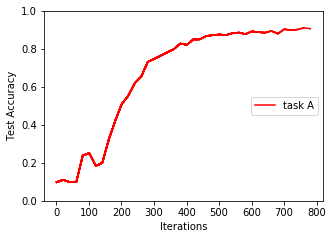

[0.90429997]


array([0.90429997])

In [9]:
train_disjoint(net,sess,800,20,mnist,[mnist],X_holder,y_holder,lams=[0.1])

In [10]:
#net.set_kalman_params(sess)

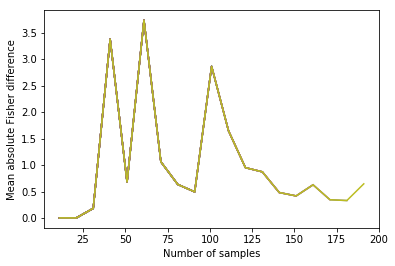

In [11]:
net.store()
#net.set_prior(sess)
#net.set_kalman_params(sess)
net.compute_fisher(mnist.validation.images,sess,plot_diffs=True)
#net.store_fisher()

In [12]:
#net.set_mask(sess,2)

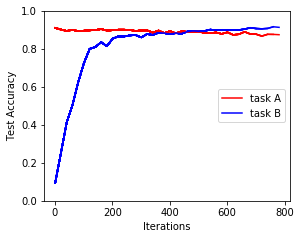

[0.         0.89235002 0.        ]


array([0.        , 0.89235002, 0.        ])

In [13]:
train_disjoint(net,sess,800,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[0,15,0])

In [14]:
#net.store()
#net.set_prior(sess)
#net.set_kalman_merge(sess)

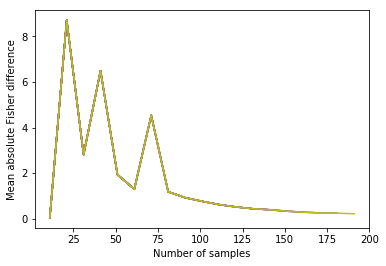

In [15]:
net.compute_fisher(mnist2.validation.images,sess,plot_diffs=True)
#net.kalman_fisher_merge(sess)
#net.set_kalman_params(sess)

In [16]:
#net.set_kalman_params(sess)

In [17]:
#acc = eval_acc(net,sess,[mnist,mnist2],X_holder,y_holder)
#print(acc)

In [18]:
'''
best_acc = 0.0
best_alpha = 0.0
for alpha in np.linspace(0,1):
    net.dist_mean_merge(sess,alpha)
    acc = eval_acc(net,sess,[mnist,mnist2],X_holder,y_holder)
    if acc > best_acc:
        best_acc = acc
        best_alpha = alpha
print(best_acc,best_alpha)
'''

'\nbest_acc = 0.0\nbest_alpha = 0.0\nfor alpha in np.linspace(0,1):\n    net.dist_mean_merge(sess,alpha)\n    acc = eval_acc(net,sess,[mnist,mnist2],X_holder,y_holder)\n    if acc > best_acc:\n        best_acc = acc\n        best_alpha = alpha\nprint(best_acc,best_alpha)\n'

In [19]:
'''
best_acc = 0.0
best_alpha = 0.0
for alpha in np.linspace(0,1):
    net.dist_fisher_merge(sess,alpha)
    acc = eval_acc(net,sess,[mnist,mnist2],X_holder,y_holder)
    if acc > best_acc:
        best_acc = acc
        best_alpha = alpha
print(best_acc,best_alpha)
'''

'\nbest_acc = 0.0\nbest_alpha = 0.0\nfor alpha in np.linspace(0,1):\n    net.dist_fisher_merge(sess,alpha)\n    acc = eval_acc(net,sess,[mnist,mnist2],X_holder,y_holder)\n    if acc > best_acc:\n        best_acc = acc\n        best_alpha = alpha\nprint(best_acc,best_alpha)\n'

In [20]:
#print(net.Pre_F_accum[1])

In [21]:
#eval_acc(net,sess,[mnist,mnist2],X_holder,y_holder)

In [22]:
net.store()
#net.set_prior(sess)
#net.set_kalman_params(sess)

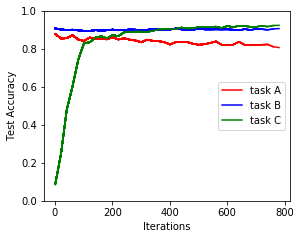

[0.         0.87759999 0.        ]


array([0.        , 0.87759999, 0.        ])

In [23]:
mnist3 = permute(mnist,1) 
train_disjoint(net,sess,800,20,mnist3,[mnist,mnist2,mnist3],X_holder,y_holder,lams=[0,15,0])

In [24]:
net.set_kalman_merge(sess)
eval_acc(net,sess,[mnist,mnist2],X_holder,y_holder)
net.store()
net.set_prior(sess)
net.set_kalman_params(sess)
eval_acc(net,sess,[mnist,mnist2],X_holder,y_holder)

AttributeError: 'BNN_MLP' object has no attribute 'kalman_uncertain'

In [ ]:
#train_disjoint(net,sess,800,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[15.0,0,0.1])

In [ ]:
#net.compute_fisher(mnist.validation.images,sess,plot_diffs=True)

In [ ]:
#net.store()
#net.set_prior(sess)

In [ ]:
mnist4 = permute(mnist,2)
train_disjoint(net,sess,800,20,mnist4,[mnist,mnist2,mnist3],X_holder,y_holder,lams=[0.1,0,0.1])